# Astronomy Wordle Game System
# A fully functional Wordle-style game using astronomy terminology

# Project Overview


This project implements a complete Wordle-style game using 5-letter astronomy terms.
Players have 6 attempts to guess the word, receiving color-coded feedback after each guess:
- GREEN: Letter is correct and in the right position
- YELLOW: Letter is in the word but in the wrong position
- GRAY: Letter is not in the word

The system tracks player statistics, provides LLM-generated hints, and offers educational
content about each astronomy term after the game concludes.



# Setting Up
    Uses pip install to install the extra packages needed
    Imports everything I use throughout the project

In [1]:
!pip install anthropic
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from datetime import datetime
import anthropic
import getpass
import os

# Class 1: WordBank
    Manages the collection of astronomy words organized by difficulty level.
    This class handles word storage, retrieval, and validation. Words are categorized
    into three difficulty levels based on obscurity and common usage in astronomy.


In [2]:
class WordBank:
    
    def __init__(self):
        """Initialize the word bank with astronomy terms organized by difficulty."""
        self.words = {
            'easy': ['COMET', 'ORBIT', 'VENUS', 'EARTH', 'STARS', 'ROVER', 
                    'PROBE', 'SOLAR', 'LUNAR', 'FLARE'],
            'medium': ['DWARF', 'QUARK', 'SAGAN', 'GAMMA', 'SOLAR', 'PLUTO',
                      'ARIES', 'PHASE', 'ALIEN', 'TITAN'],
            'hard': ['BRAHE', 'METIS', 'APSIS', 'EULER', 'NADIR',
                    'EPOCH', 'CERES', 'LIBRA', 'MIMAS', 'UMBRA']
        }
        self.all_words = [word for level in self.words.values() for word in level]
    
    def get_random_word(self, difficulty='medium'):
        """
        Retrieve a random word from the specified difficulty level.
        
        Args:
            difficulty (str): Difficulty level ('easy', 'medium', 'hard')
        
        Returns:
            str: A random 5-letter astronomy term
        """
        if difficulty not in self.words:
            difficulty = 'medium'
        return random.choice(self.words[difficulty])
     
    def is_valid_word(self, word):
        """
        Check if a word is in the word bank.
        
        Args:
            word (str): Word to validate
        
        Returns:
            bool: True if word exists in bank, False otherwise
        """
        return word.upper() in self.all_words


# Class 2: GameState
    Manages the current state of a Wordle game session.
    This class tracks all game-related information including guesses, the target word,
    remaining attempts, and letter status throughout the game.
    
    

In [3]:
class GameState:
   
    def __init__(self, target_word):
        """
        Initialize a new game state.
        
        Args:
            target_word (str): The 5-letter word to be guessed
        """
        self.target_word = target_word.upper()
        self.guesses = []
        self.max_attempts = 6
        self.game_over = False
        self.won = False
        self.letter_status = {}  # Tracks color status of each letter
        
    def add_guess(self, guess):
        """
        Add a guess to the game state and check for win condition.
        
        Args:
            guess (str): The player's guess
        """
        self.guesses.append(guess.upper())
        if guess.upper() == self.target_word:
            self.won = True
            self.game_over = True
        elif len(self.guesses) >= self.max_attempts:
            self.game_over = True
            
    def get_remaining_attempts(self):
        """Return the number of attempts remaining."""
        return self.max_attempts - len(self.guesses)
    
    def check_guess(self, guess):
        """
        Evaluate a guess and return color-coded feedback.
        
        Args:
            guess (str): The player's 5-letter guess
        
        Returns:
            list: List of tuples (letter, color) for each position
        """
        guess = guess.upper()
        result = []
        target_letters = list(self.target_word)
        guess_letters = list(guess)
        
        # First pass: Mark correct positions (GREEN)
        for i in range(5):
            if guess_letters[i] == target_letters[i]:
                result.append((guess_letters[i], 'GREEN'))
                target_letters[i] = None  # Mark as used
                guess_letters[i] = None
            else:
                result.append((guess_letters[i], None))
        
        # Second pass: Mark wrong positions (YELLOW) and not in word (GRAY)
        for i in range(5):
            if guess_letters[i] is not None:
                if guess_letters[i] in target_letters:
                    result[i] = (result[i][0], 'YELLOW')
                    target_letters[target_letters.index(guess_letters[i])] = None
                else:
                    result[i] = (result[i][0], 'GRAY')
          
                # Update letter status dictionary
                letter = result[i][0]
                color = result[i][1]
                if letter not in self.letter_status:
                    self.letter_status[letter] = color
                elif color == 'GREEN':
                    self.letter_status[letter] = 'GREEN'
                elif color == 'YELLOW' and self.letter_status[letter] != 'GREEN':
                    self.letter_status[letter] = 'YELLOW'
        
        return result

          

# Class 3: WordleGame
    Main game controller that orchestrates the Wordle game experience.
    This class manages game flow, user interaction, statistics tracking, and
    integration with the LLM for hints and educational content.
    
    

In [4]:
class WordleGame:

    def __init__(self, api_key=None):
        """
        Initialize the Wordle game system.
        
        Args:
            api_key (str): Anthropic API key for LLM integration (optional)
        """
        self.word_bank = WordBank()
        self.current_game = None
        self.statistics = {
            'games_played': 0,
            'games_won': 0,
            'current_streak': 0,
            'max_streak': 0,
            'guess_distribution': np.zeros(6)
        }
        self.api_key = api_key
        self.client = anthropic.Anthropic(api_key=api_key) if api_key else None
        
    def start_new_game(self, difficulty='medium'):
        """
        Start a new game with a random word from the specified difficulty.
        
        Args:
            difficulty (str): Difficulty level for word selection
        """
        target_word = self.word_bank.get_random_word(difficulty)
        self.current_game = GameState(target_word)
        print("🌟 Welcome to Astronomy Wordle! 🌟")
        print(f"\nGuess the 5-letter astronomy term. You have {self.current_game.max_attempts} attempts.")
        print("After each guess, you'll see color-coded feedback:")
        print("🟩 GREEN = Correct letter in correct position")
        print("🟨 YELLOW = Correct letter in wrong position")
        print("⬜ GRAY = Letter not in word\n")
    
    def display_guess_result(self, result):
        """
        Display the color-coded result of a guess.
        
        Args:
            result (list): List of (letter, color) tuples
        """
        color_map = {
            'GREEN': '🟩',
            'YELLOW': '🟨',
            'GRAY': '⬜'
        }
        
        display = ""
        letters = ""
        for letter, color in result:
            display += color_map[color] + " "
            letters += letter + " "
        
        print(letters)
        print(display)
    
    def get_llm_hint(self, game_state):
        """
        Generate a contextual hint using the LLM API without revealing the answer.
        Args:
            game_state (GameState)
        Returns:
            str: A helpful hint about the word
        """
        if not self.client:
            return "Hint system requires API key. Think about common astronomy terms!"
        
        try:
            prompt = f"""You are helping a player in an astronomy Wordle game. The word they're trying to guess is "{game_state.target_word}".
            
They have made {len(game_state.guesses)} guesses so far: {', '.join(game_state.guesses) if game_state.guesses else 'none yet'}.

Provide a helpful hint about this astronomy term WITHOUT revealing the word itself. The hint should:
- Be 1-2 sentences maximum
- Give context about what the term relates to in astronomy
- Not contain any letters from the target word if possible
- Be educational and interesting

Hint:"""
            
            message = self.client.messages.create(
                model="claude-sonnet-4-5-20250929",
                max_tokens=150,
                messages=[{"role": "user", "content": prompt}]
            )
            
            return message.content[0].text.strip()
        
        except Exception as e:
            return f"Unable to generate hint at this time. Keep trying!"
    
    def get_educational_content(self, word):
        """
        Generate educational explanation about the astronomy term after game ends.
        
        Args:
            word (str): The astronomy term to explain
        
        Returns:
            str: Educational content about the term
        """
        if not self.client:
            return f"The word was {word}. Look it up to learn more about this astronomy term!"
        
        try:
            prompt = f"""Provide a brief, educational explanation (3-4 sentences) about the astronomy term "{word}". 
Include what it is, why it's significant in astronomy, and an interesting fact. Make it accessible to beginners."""
            
            message = self.client.messages.create(
                model="claude-sonnet-4-5-20250929",
                max_tokens=200,
                messages=[{"role": "user", "content": prompt}]
            )
            
            return message.content[0].text.strip()
        
        except Exception as e:
            return f"The word was {word}. Research this term to expand your astronomy knowledge!"
    
    def play_turn(self, guess):
        """
        Process a single turn of the game.
        
        Args:
            guess (str): Player's guess
        
        Returns:
            bool: True if game continues, False if game is over
        """
        if self.current_game is None:
            print("No active game. Start a new game first!")
            return False
        
        if self.current_game.game_over:
            print("Game is already over. Start a new game!")
            return False
        
        # Validate input
        try:
            guess = guess.strip().upper()
            
            if len(guess) != 5:
                raise ValueError("Guess must be exactly 5 letters")
                            
            if not guess.isalpha():
                raise ValueError("Guess must contain only letters")
            
            # Check guess and display result
            result = self.current_game.check_guess(guess)
            self.current_game.add_guess(guess)
            
            print(f"\nAttempt {len(self.current_game.guesses)}/{self.current_game.max_attempts}:")
            self.display_guess_result(result)
            
            # Check if game is over
            if self.current_game.game_over:
                self.end_game()
                return False
            
            # Offer hint after 3 failed attempts
            if len(self.current_game.guesses) == 3:
                print("\n💡 Would you like a hint? (Hint available)")
            
            print(f"\nRemaining attempts: {self.current_game.get_remaining_attempts()}")
            return True
            
        except ValueError as e:
            print(f"❌ Invalid input: {e}")
            return True
        except Exception as e:
            print(f"❌ An error occurred: {e}")
            return True
    
    def end_game(self):
        """Handle game conclusion, update statistics, and provide educational content."""
        self.statistics['games_played'] += 1
        
        if self.current_game.won:
            attempts = len(self.current_game.guesses)
            self.statistics['games_won'] += 1
            self.statistics['current_streak'] += 1
            self.statistics['guess_distribution'][attempts - 1] += 1
            
            if self.statistics['current_streak'] > self.statistics['max_streak']:
                self.statistics['max_streak'] = self.statistics['current_streak']
            
            print(f"\n🎉 Congratulations! You guessed it in {attempts} attempts!")
        else:
            self.statistics['current_streak'] = 0
            print(f"\n😢 Game Over! The word was: {self.current_game.target_word}")
        
        # Provide educational content
        print("\n📚 Learn about this term:")
        explanation = self.get_educational_content(self.current_game.target_word)
        print(explanation)
        
        self.save_statistics()
    
    def save_statistics(self, filename='wordle_stats.json'):
        """
        Save game statistics to a JSON file.
        
        Args:
            filename (str): Name of the file to save statistics
        """
        try:
            stats_to_save = self.statistics.copy()
            stats_to_save['guess_distribution'] = self.statistics['guess_distribution'].tolist()
            
            with open(filename, 'w') as f:
                json.dump(stats_to_save, f, indent=2)
        except Exception as e:
            print(f"Could not save statistics: {e}")
    
    def load_statistics(self, filename='wordle_stats.json'):
        """
        Load game statistics from a JSON file.
        
        Args:
            filename (str): Name of the file to load statistics from
        """
        try:
            with open(filename, 'r') as f:
                loaded_stats = json.load(f)
                loaded_stats['guess_distribution'] = np.array(loaded_stats['guess_distribution'])
                self.statistics = loaded_stats
        except FileNotFoundError:
            print("No previous statistics found. Starting fresh!")
        except Exception as e:
            print(f"Could not load statistics: {e}")
    
    def visualize_statistics(self):
        """Create visualizations of player statistics using Matplotlib."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Guess distribution bar chart
        attempts = np.arange(1, 7)
        axes[0].bar(attempts, self.statistics['guess_distribution'], color='steelblue', edgecolor='black')
        axes[0].set_xlabel('Number of Guesses', fontsize=12)
        axes[0].set_ylabel('Games Won', fontsize=12)
        axes[0].set_title('Guess Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xticks(attempts)
        axes[0].grid(axis='y', alpha=0.3)
        
        # Statistics summary
        axes[1].axis('off')
        win_rate = (self.statistics['games_won'] / self.statistics['games_played'] * 100) if self.statistics['games_played'] > 0 else 0
        
        stats_text = f"""
        GAME STATISTICS
        ═══════════════════════
        
        Games Played: {self.statistics['games_played']}
        Games Won: {self.statistics['games_won']}
        Win Rate: {win_rate:.1f}%
        
        Current Streak: {self.statistics['current_streak']}
        Max Streak: {self.statistics['max_streak']}
        
        Average Guesses: {np.average(attempts, weights=self.statistics['guess_distribution']) if self.statistics['games_won'] > 0 else 0:.2f}
        """
        
        axes[1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                     verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig('wordle_statistics.png', dpi=150, bbox_inches='tight')
        plt.show()


# Final Parts to the Code
    Creates text for asking the user questions
    starts the game with the selected difficultly
    displays multiple different things based on user input
    Protects my API key through getpass

Enter your Anthropic API key:  ········


Choose difficulty level:
1. Easy - Common space terms
2. Medium - Astronomy vocabulary
3. Hard - Advanced/obscure terms
4. Mixed - Random from all levels


Enter 1, 2, 3, or 4 (default is 2):  4


🌟 Welcome to Astronomy Wordle! 🌟

Guess the 5-letter astronomy term. You have 6 attempts.
After each guess, you'll see color-coded feedback:
🟩 GREEN = Correct letter in correct position
🟨 YELLOW = Correct letter in wrong position
⬜ GRAY = Letter not in word




Enter your 5-letter guess (or 'hint' for a clue, 'quit' to exit):  space



Attempt 1/6:
S P A C E 
🟩 ⬜ 🟨 ⬜ ⬜ 

Remaining attempts: 5



Enter your 5-letter guess (or 'hint' for a clue, 'quit' to exit):  shoot



Attempt 2/6:
S H O O T 
🟩 ⬜ 🟨 ⬜ ⬜ 

Remaining attempts: 4



Enter your 5-letter guess (or 'hint' for a clue, 'quit' to exit):  sonar



Attempt 3/6:
S O N A R 
🟩 🟩 ⬜ 🟩 🟩 

💡 Would you like a hint? (Hint available)

Remaining attempts: 3



Enter your 5-letter guess (or 'hint' for a clue, 'quit' to exit):  hint



💡 Hint: This term describes anything relating to the bright, hot body at the center of our planetary system, which provides light and warmth to Earth.



Enter your 5-letter guess (or 'hint' for a clue, 'quit' to exit):  solar



Attempt 4/6:
S O L A R 
🟩 🟩 🟩 🟩 🟩 

🎉 Congratulations! You guessed it in 4 attempts!

📚 Learn about this term:
# Solar

**Solar** refers to anything related to or originating from the Sun, our closest star and the center of our solar system. The term is significant in astronomy because the Sun is fundamental to understanding planetary science, stellar physics, and life on Earth—it provides the energy that drives our weather, climate, and photosynthesis. An interesting fact is that the Sun is so massive that it contains 99.8% of all the mass in our entire solar system, meaning all the planets, moons, asteroids, and comets combined make up less than 0.2%! Scientists study solar phenomena like sunspots, solar flares, and solar wind to better predict space weather that can affect satellites and communications on Earth.




Would you like to view your statistics? (yes/no):  yes



PLAYER STATISTICS


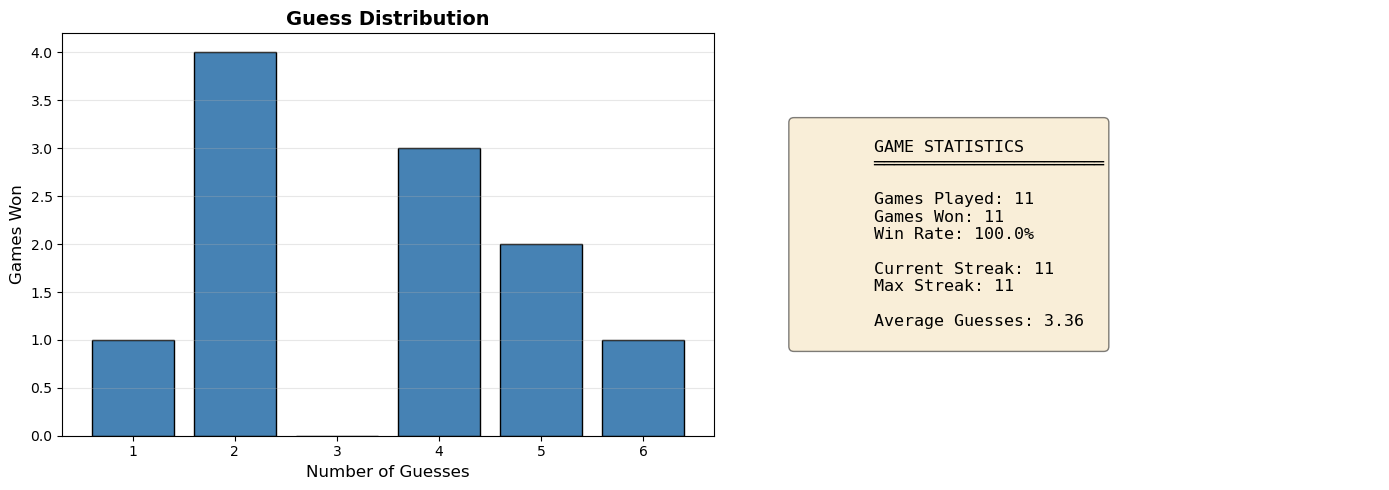

In [ ]:
# Initialize the game (replace with your actual API key or None for basic mode)

api_key = getpass.getpass("Enter your Anthropic API key: ")
os.environ["ANTHROPIC_API_KEY"] = api_key
api_key = os.environ.get("ANTHROPIC_API_KEY", None)
game = WordleGame(api_key=api_key)

# Load previous statistics if available
game.load_statistics()


# Ask for difficulty and start a new game
print("Choose difficulty level:")
print("1. Easy - Common space terms")
print("2. Medium - Astronomy vocabulary")
print("3. Hard - Advanced/obscure terms")
print("4. Mixed - Random from all levels")

difficulty_choice = input("Enter 1, 2, 3, or 4 (default is 2): ").strip()
difficulty_map = {'1': 'easy', '2': 'medium', '3': 'hard', '4': 'all'}
chosen_difficulty = difficulty_map.get(difficulty_choice, 'medium')

game.start_new_game(difficulty=chosen_difficulty)

# Interactive gameplay loop
while not game.current_game.game_over:
    guess = input("\nEnter your 5-letter guess (or 'hint' for a clue, 'quit' to exit): ").strip().upper()
    
    if guess == 'QUIT':
        print("Thanks for playing!")
        break
    elif guess == 'HINT':
        hint = game.get_llm_hint(game.current_game)
        print(f"\n💡 Hint: {hint}")
        continue
    
    continues = game.play_turn(guess)
    if not continues:
        break

# Ask if player wants to see statistics
view_stats = input("\n\nWould you like to view your statistics? (yes/no): ").strip().lower()
if view_stats in ['yes', 'y']:
    print("\n" + "="*50)
    print("PLAYER STATISTICS")
    print("="*50)
    game.visualize_statistics()

# Ask if player wants to play again
play_again = input("\nWould you like to play again? (yes/no): ").strip().lower()
if play_again in ['yes', 'y']:
    game.start_new_game(difficulty='medium')
    
    # Another gameplay loop for the new game
    while not game.current_game.game_over:
        guess = input("\nEnter your 5-letter guess (or 'hint' for a clue, 'quit' to exit): ").strip().upper()
        
        if guess == 'QUIT':
            print("Thanks for playing!")
            break
        elif guess == 'HINT':
            hint = game.get_llm_hint(game.current_game)
            print(f"\n💡 Hint: {hint}")
            continue
        
        continues = game.play_turn(guess)
        if not continues:
            break

print("\n🌟 Thanks for playing Astronomy Wordle! 🌟")

# Conclusion
    I, Evan, was responsilbe for the contriubution of the entire project
    This was my first time coding a project from scrath, and I had a lot of fun and learned a lot
    Github Repo: https://github.com/Evan-Stiverson/Astro_Data_Project_1